Импорт необходимых библиотек

In [96]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
from math import sqrt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

from keras.models import Sequential
from keras.layers import Dense, Dropout, LayerNormalization
import keras
from keras import initializers , optimizers

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [3]:
!pip install catboost -q
from catboost import CatBoostRegressor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


Функция для оценки моделей

In [4]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

def get_metrics(y_pred):
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  print(f'Mean Squared Error: {mse}')
  print(f'R2 Score: {r2}')
  print(f'Mean Absolute Error:  {mae}')
  print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')

Загрузка и предобработка данных

In [71]:
df = pd.read_csv("/content/chem_data (2).csv")

In [72]:
df.head(2)

,AtomicWeight,MeltingT,Column,Row,CovalentRadius,Electronegativity,NsValence,NpValence,NdValence,NfValence,NValence,NsUnfilled,NpUnfilled,NdUnfilled,NUnfilled,GSvolume_pa,GSbandgap,GSmagmom,SpaceGroupNumber,K_VRH
0,76.440703,2409.166667,7.166667,4.5,148.833333,1.696667,1.333333,0.333333,3.833333,0.0,5.5,0.666667,0.666667,4.5,5.833333,17.234167,0.128833,0.258079,222.833333,194.268884
1,40.203786,1568.694000,11.800000,3.4,119.000000,1.834000,2.000000,1.000000,2.800000,0.0,5.8,0.000000,2.600000,1.2,3.800000,15.570000,0.309200,0.619388,213.400000,175.449907


In [73]:
df.shape

(1180, 20)

In [74]:
print("\nПропуски в данных:\n", df.isna().sum())


Пропуски в данных:
 AtomicWeight         0
MeltingT             0
Column               0
Row                  0
CovalentRadius       0
Electronegativity    0
NsValence            0
NpValence            0
NdValence            0
NfValence            0
NValence             0
NsUnfilled           0
NpUnfilled           0
NdUnfilled           0
NUnfilled            0
GSvolume_pa          0
GSbandgap            0
GSmagmom             0
SpaceGroupNumber     0
K_VRH                0
dtype: int64


In [75]:
corr_matrix = df.corr()

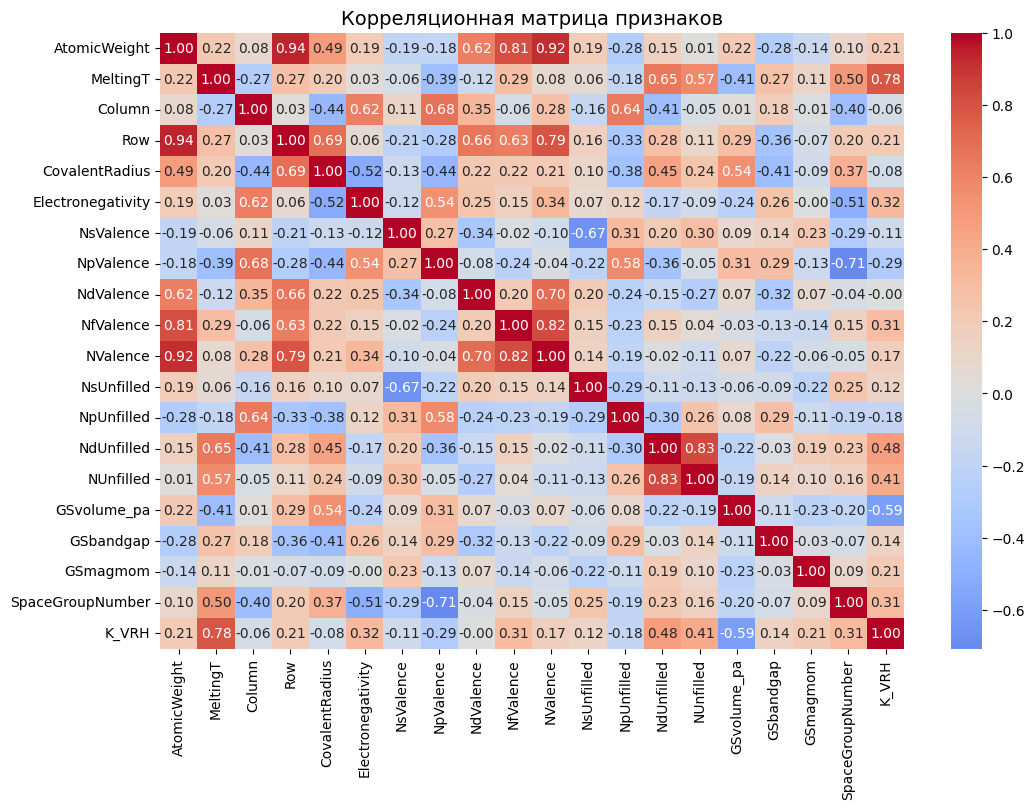

In [76]:
# Строим тепловую карту
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Корреляционная матрица признаков", fontsize=14)
plt.show()

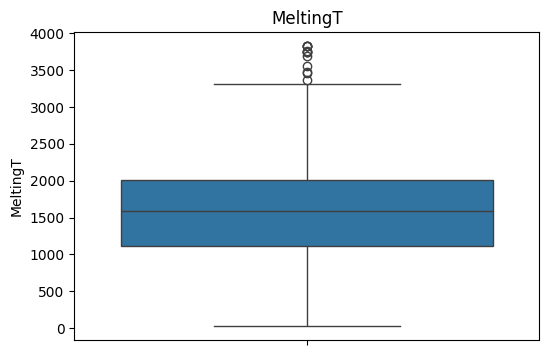

In [77]:
plt.figure(figsize=(6,4))
sns.boxplot(y=df['MeltingT'])
plt.title("MeltingT")
plt.show()

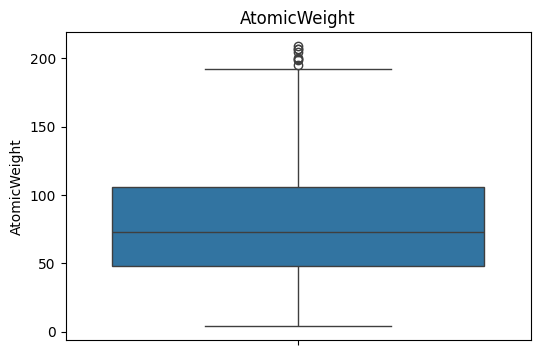

In [78]:
plt.figure(figsize=(6,4))
sns.boxplot(y=df['AtomicWeight'])
plt.title("AtomicWeight")
plt.show()

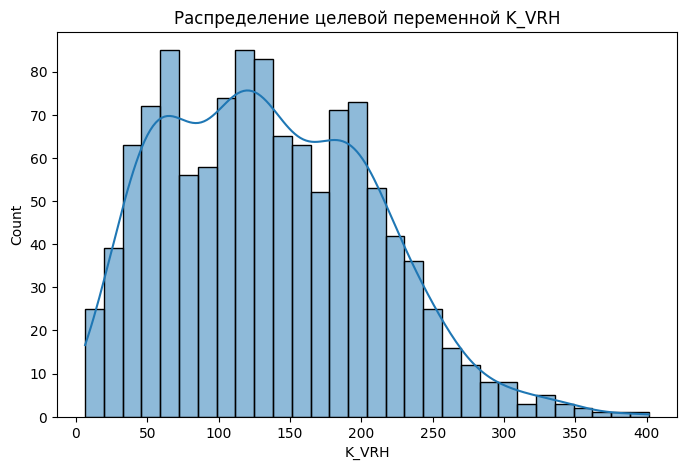

In [79]:
plt.figure(figsize=(8,5))
sns.histplot(df['K_VRH'], bins=30, kde=True)
plt.title("Распределение целевой переменной K_VRH")
plt.show()

Деление на признаки и тагрет

In [80]:
y = df['K_VRH']
X = df.drop('K_VRH',axis = 1)

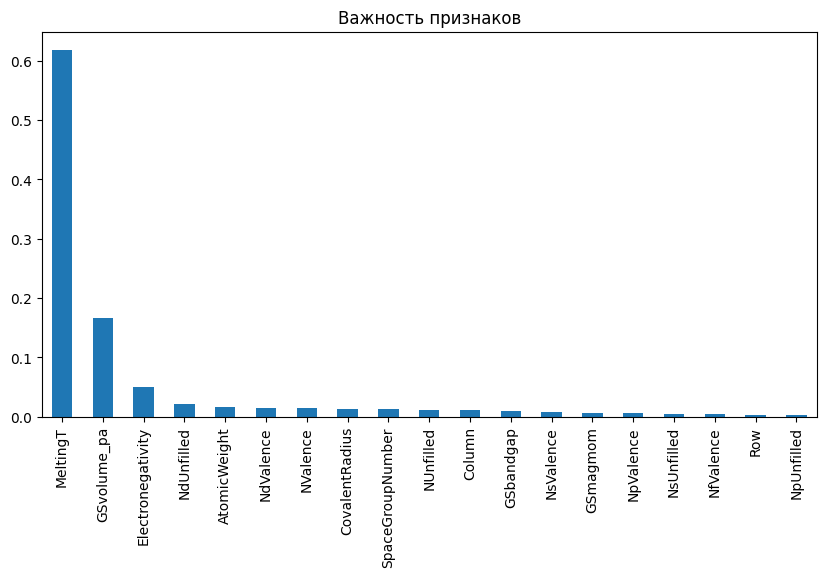

In [81]:
rf = RandomForestRegressor()
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title("Важность признаков")
plt.show()

In [82]:
X = X.drop(columns = ['Row', 'Column', 'CovalentRadius', 'NsValence', 'NdValence', 'NValence', 'NsUnfilled', 'NpUnfilled'], axis = 1)

In [70]:
X.head()

,AtomicWeight,MeltingT,Electronegativity,NpValence,NfValence,NdUnfilled,NUnfilled,GSvolume_pa,GSbandgap,GSmagmom,SpaceGroupNumber
0,76.440703,2409.166667,1.696667,0.333333,0.0,4.5,5.833333,17.234167,0.128833,0.258079,222.833333
1,40.203786,1568.694000,1.834000,1.000000,0.0,1.2,3.800000,15.570000,0.309200,0.619388,213.400000
2,109.157750,2496.500000,2.050000,1.000000,7.0,2.0,4.000000,17.265000,0.386500,0.000000,210.500000
3,69.723000,302.910000,1.810000,1.000000,0.0,0.0,5.000000,18.857500,0.000000,0.000000,64.000000
4,76.741833,2300.333333,2.100000,0.666667,0.0,2.0,4.000000,15.820000,0.257667,0.000000,205.000000


Деление данных на train / val / test и масштабирование признаков

In [91]:

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)


scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Использование различных моделей

In [92]:
print("Размер train:", X_train.shape)
print("Размер val:", X_val.shape)
print("Размер test:", X_test.shape)

Размер train: (826, 11)
Размер val: (177, 11)
Размер test: (177, 11)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from scipy.stats import randint, uniform

cat = CatBoostRegressor(verbose=0, random_state=42)

param_dist_cat = {
    "depth": randint(4, 10),
    "learning_rate": uniform(0.01, 0.2),
    "iterations": randint(200, 1000),
    "l2_leaf_reg": randint(1, 10)
}

random_search_cat = RandomizedSearchCV(
    cat,
    param_distributions=param_dist_cat,
    n_iter=20,
    cv=3,
    scoring="r2",
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_cat.fit(X_train, y_train)

print("Лучшие параметры CatBoost:", random_search_cat.best_params_)
print("Лучший R2 на валидации:", random_search_cat.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [59]:
model = LinearRegression()
model.fit(X_train, y_train)

intercept = model.intercept_
slope = model.coef_[0]

score = model.score(X_test, y_test)
y_pred = model.predict(X_test)
get_metrics(y_pred)

Mean Squared Error: 1070.4156626096158
R2 Score: 0.7847733067906213
Mean Absolute Error:  25.222330745930037
MAPE: 0.45728725293728334


In [64]:
model = ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_metrics(y_pred)

Mean Squared Error: 1356.1199386867802
R2 Score: 0.7273272241857056
Mean Absolute Error:  29.818312691223866
MAPE: 0.44869620184919645


In [60]:
RF_model = RandomForestRegressor()
RF_model.fit(X_train, y_train)
y_pred_rf = RF_model.predict(X_test)
get_metrics(y_pred_rf)

Mean Squared Error: 478.90571128690965
R2 Score: 0.903707226828053
Mean Absolute Error:  14.173332644994415
MAPE: 0.17808372966880934


In [61]:
model_cat = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=0)
model_cat.fit(X_train, y_train)
y_pred_cat = model_cat.predict(X_test)
get_metrics(y_pred_cat)

Mean Squared Error: 378.0986972904031
R2 Score: 0.923976325116362
Mean Absolute Error:  11.468657719417283
MAPE: 0.12351006966883574


In [62]:
init = initializers.TruncatedNormal(mean = 0, stddev = 0.05, seed = 1)
model_nn = Sequential()
model_nn.add(Dense(44, input_dim = 11, activation = 'relu', kernel_initializer = init))
model_nn.add(LayerNormalization())
model_nn.add(Dense(70, activation = 'relu'))
model_nn.add(Dense(1, activation = 'linear'))


loss_fn = keras.losses.MeanAbsoluteError()
sgd = optimizers.SGD(learning_rate = 0.0001, momentum=0.8, nesterov=True)
model_nn.compile(loss = loss_fn, optimizer = sgd)
model_nn.fit(X_train, y_train, epochs=100, batch_size = 48, verbose=0)

y_pred_nn = model_nn.predict(X_test)
get_metrics(y_pred_nn)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Mean Squared Error: 474.03586422372103
R2 Score: 0.9046863988604299
Mean Absolute Error:  14.654024769210604
MAPE: 0.18889469517859098


График предсказанных значений и истинных

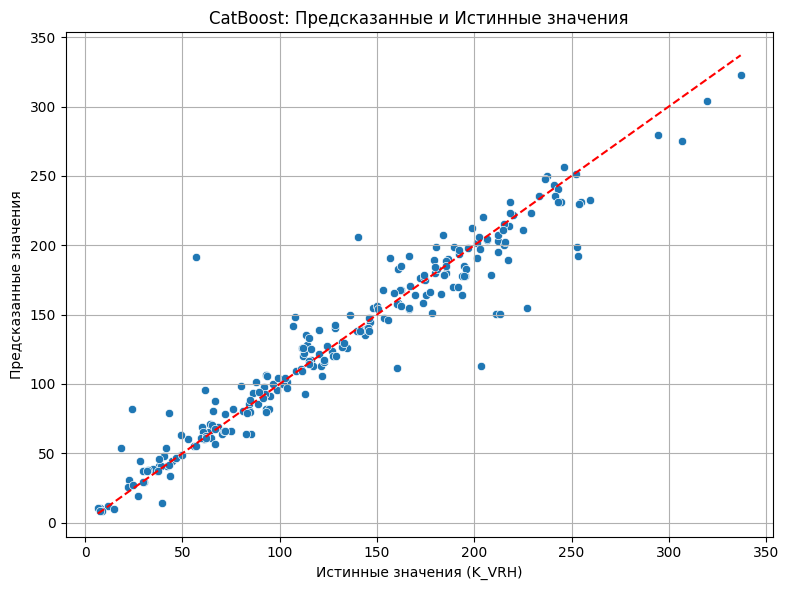

In [84]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_cat)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Истинные значения (K_VRH)')
plt.ylabel('Предсказанные значения')
plt.title('CatBoost: Предсказанные и Истинные значения')
plt.grid(True)
plt.tight_layout()
plt.show()


Анализ предсказаний

In [85]:
X_test_df = pd.DataFrame(X_test, columns=X.columns)
X_test_df = X_test_df.reset_index(drop=True)
y_test_df = y_test.reset_index(drop=True)

y_pred_series = pd.Series(y_pred_cat, name='Предсказанное значение')
full_df = pd.concat([X_test_df, y_test_df.rename('Истинное значение'), y_pred_series], axis=1)


sample = full_df.sample(20, random_state=42)
sample

,AtomicWeight,MeltingT,Electronegativity,NpValence,NfValence,NdUnfilled,NUnfilled,GSvolume_pa,GSbandgap,GSmagmom,SpaceGroupNumber,Истинное значение,Предсказанное значение
69,-0.501999,0.519793,0.451969,0.147043,-0.594031,0.115076,0.219003,-0.633428,1.084785,3.296067,0.143572,139.990018,205.750418
190,-1.179973,-0.484301,-1.080885,0.398124,-0.594031,-1.096540,-0.298777,0.915064,0.042618,-0.344177,0.758526,57.093192,55.270216
181,-0.774056,0.324274,-0.257876,-0.355119,-0.594031,0.417980,0.115447,-1.215247,1.084785,-0.343642,0.241887,192.083759,196.899036
9,0.760044,-0.341310,0.624801,0.649205,-0.594031,-0.490732,0.219003,0.984459,-0.375960,-0.344177,-1.076699,127.080359,123.537364
127,-0.359939,0.410612,-1.152898,-0.857281,0.685606,0.249700,-0.471370,-0.860182,-0.375960,-0.344177,-0.157158,128.485270,142.532675
109,-0.721180,0.730134,-0.720819,-0.857281,-0.594031,1.932501,1.599748,-0.807471,-0.375960,-0.344155,0.517557,196.805773,198.238782
229,-0.865616,-0.206315,-0.412190,0.147043,-0.594031,-1.096540,-0.816556,0.227598,0.126333,-0.344177,0.762382,92.907869,79.839948
93,0.650646,1.401368,0.143341,0.398124,1.325425,0.165560,0.477893,-0.151123,0.251907,-0.344177,0.319962,246.269738,256.668592
150,-1.125894,-0.449996,-0.823695,-0.020344,-0.594031,0.249700,1.254562,-0.295836,-0.375960,-0.344155,0.440446,108.174701,109.572573
15,1.039158,-1.380791,0.544558,2.908935,-0.594031,-1.096540,-0.298777,2.239244,0.000922,-0.344177,-1.530686,39.548343,14.069129
